In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 已经加载了历史数据
data = pd.read_csv("C:/Users/12/Desktop/financial_data_log.csv", index_col='Date', parse_dates=True)

# 检查是否有零值
zero_values = (data == 0).sum()
print("Initial zero values count per asset:\n", zero_values)

# 选择性处理零值
# 方法1：用相邻非零值的平均值替换零值
data = data.replace(0, np.nan)  # 先将零值替换为 NaN
data = data.interpolate(method='linear', limit_direction='both')  # 线性插值

# 再次检查零值
zero_values_after = (data == 0).sum()
print("Zero values count after interpolation:\n", zero_values_after)

# 显示清洗后的数据
print("Data after zero-value processing:\n", data.head())
# 模拟生成最新的市场数据

def get_latest_data(num_samples=500):
    dates = pd.date_range(end=pd.Timestamp.today(), periods=num_samples, freq='B')  # B for business days
    new_data = pd.DataFrame({
        'AAPL': np.random.normal(0, 0.02, num_samples),
        'MSFT': np.random.normal(0, 0.02, num_samples),
        'SPY': np.random.normal(0, 0.02, num_samples),
        'TLT': np.random.normal(0, 0.02, num_samples)
    }, index=dates)
    return new_data

# 生成并查看数据
new_data = get_latest_data(500)
print(new_data.head())


Initial zero values count per asset:
 AAPL    2
MSFT    0
SPY     2
TLT     1
dtype: int64
Zero values count after interpolation:
 AAPL    0
MSFT    0
SPY     0
TLT     0
dtype: int64
Data after zero-value processing:
                                AAPL      MSFT       SPY       TLT
Date                                                             
2022-01-04 00:00:00+00:00 -0.012773 -0.017296 -0.000335 -0.004167
2022-01-05 00:00:00+00:00 -0.026960 -0.039144 -0.019389 -0.005443
2022-01-06 00:00:00+00:00 -0.016834 -0.007933 -0.000940  0.002585
2022-01-07 00:00:00+00:00  0.000988  0.000509 -0.003961 -0.007214
2022-01-10 00:00:00+00:00  0.000116  0.000732 -0.001245  0.002457
                                AAPL      MSFT       SPY       TLT
2022-12-13 13:44:36.684553  0.020587  0.003952  0.006229 -0.011735
2022-12-14 13:44:36.684553 -0.009126 -0.025596  0.005323 -0.031382
2022-12-15 13:44:36.684553 -0.005156  0.020004 -0.031745  0.020738
2022-12-16 13:44:36.684553 -0.025611 -0.028471  0.0

In [8]:
# 合并历史数据和生成的最新数据
full_data = pd.concat([data, new_data])
print("Data after merging historical and new data:\n", full_data.tail())


Data after merging historical and new data:
                                 AAPL      MSFT       SPY       TLT
2024-11-05 13:44:36.684553  0.008298  0.006645 -0.036936  0.000557
2024-11-06 13:44:36.684553  0.047959  0.001172  0.004162 -0.027849
2024-11-07 13:44:36.684553 -0.010236  0.045028 -0.004627 -0.030390
2024-11-08 13:44:36.684553  0.036530 -0.000078  0.003561  0.023502
2024-11-11 13:44:36.684553  0.020564 -0.030671 -0.003841  0.014409


In [14]:
# 先将零或负值替换为 NaN
full_data = full_data.replace(0, np.nan)  # 将零值替换为 NaN
full_data[full_data <= 0] = np.nan  # 将所有非正值（包括负值和零）替换为 NaN

# 计算对数收益率
log_returns = np.log(full_data / full_data.shift(1))

# 填补或删除 NaN 值
log_returns = log_returns.ffill().dropna()


print("Log returns after merging and calculation:\n", log_returns.tail())



Log returns after merging and calculation:
                                 AAPL      MSFT      SPY       TLT
2024-11-05 13:44:36.684553 -0.370531 -1.404511  1.03415 -0.196116
2024-11-06 13:44:36.684553  1.754371 -1.734780  1.03415 -0.196116
2024-11-07 13:44:36.684553  1.754371  3.648168  1.03415 -0.196116
2024-11-08 13:44:36.684553  1.754371  3.648168  1.03415 -0.196116
2024-11-11 13:44:36.684553 -0.574606  3.648168  1.03415 -0.489253


In [20]:
# 设置滚动窗口大小
window_size = 60

# 确保 returns 变量已定义
returns = log_returns

# 滚动计算 VaR
rolling_VaR = returns.rolling(window=window_size).quantile(0.05)

# 检查符合 ES 计算条件的数据点数量，首先对齐两者的索引
aligned_returns, aligned_VaR = returns.align(rolling_VaR, join='inner')

# 过滤出符合 VaR 条件的数据点，并统计数量
es_condition_counts = (aligned_returns <= aligned_VaR).sum()
print("Data points within VaR threshold for ES calculation:\n", es_condition_counts)

# 在 ES 计算中，将符合条件的返回使用前值填充，以减少 NaN 的传播
filtered_returns = aligned_returns.where(aligned_returns <= aligned_VaR).ffill()

# 计算滚动的 VaR 和 ES
rolling_VaR = returns.rolling(window=window_size).quantile(0.05)
rolling_ES = filtered_returns.rolling(window=window_size).mean()

# 去除可能的空缺值
rolling_VaR = rolling_VaR.dropna(how='all')
rolling_ES = rolling_ES.dropna(how='all')

# 检查并打印最后几行结果
print("Final Rolling VaR:\n", rolling_VaR.tail())
print("Final Rolling ES:\n", rolling_ES.tail())



Data points within VaR threshold for ES calculation:
 AAPL    109
MSFT     87
SPY     105
TLT     127
dtype: int64
Final Rolling VaR:
                                 AAPL      MSFT       SPY       TLT
2024-11-05 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
2024-11-06 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
2024-11-07 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
2024-11-08 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
2024-11-11 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
Final Rolling ES:
                                 AAPL      MSFT       SPY       TLT
2024-11-05 13:44:36.684553 -3.272764 -1.676877 -1.789650 -1.637149
2024-11-06 13:44:36.684553 -3.281810 -1.703101 -1.806984 -1.612527
2024-11-07 13:44:36.684553 -3.290857 -1.729326 -1.824318 -1.587905
2024-11-08 13:44:36.684553 -3.299903 -1.755551 -1.841653 -1.563284
2024-11-11 13:44:36.684553 -3.308950 -1.781776 -1.858987 -1.538662


In [24]:
# 保存 VaR 和 ES 结果到 CSV 文件
rolling_VaR.to_csv("C:/Users/12/Desktop/system_VaR.csv", index_label="Date")
rolling_ES.to_csv("C:/Users/12/Desktop/system_ES.csv", index_label="Date")
print("VaR and ES results saved with Date index.")


VaR and ES results saved with Date index.


In [25]:
# 保存清理后的对数收益率数据到 CSV 文件，以便后续使用
log_returns.to_csv("C:/Users/12/Desktop/cleaned_log_returns.csv",index_label="Date")
print("Cleaned log returns saved successfully for future tasks.")


Cleaned log returns saved successfully for future tasks.


In [26]:
#第六天
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

# 加载之前保存的 VaR 和 ES 数据，方便后续回测
rolling_VaR = pd.read_csv("C:/Users/12/Desktop/system_VaR.csv", index_col='Date', parse_dates=True)
rolling_ES = pd.read_csv("C:/Users/12/Desktop/system_ES.csv", index_col='Date', parse_dates=True)

# 加载清理后的对数收益率数据
log_returns = pd.read_csv("C:/Users/12/Desktop/cleaned_log_returns.csv", index_col='Date', parse_dates=True)

# 检查加载的数据
print("Rolling VaR Data Sample:\n", rolling_VaR.tail())
print("Rolling ES Data Sample:\n", rolling_ES.tail())
print("Log Returns Data Sample:\n", log_returns.tail())


Rolling VaR Data Sample:
                                 AAPL      MSFT       SPY       TLT
Date                                                              
2024-11-05 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
2024-11-06 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
2024-11-07 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
2024-11-08 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
2024-11-11 13:44:36.684553 -3.553208 -2.658239 -2.370204 -0.573699
Rolling ES Data Sample:
                                 AAPL      MSFT       SPY       TLT
Date                                                              
2024-11-05 13:44:36.684553 -3.272764 -1.676877 -1.789650 -1.637149
2024-11-06 13:44:36.684553 -3.281810 -1.703101 -1.806984 -1.612527
2024-11-07 13:44:36.684553 -3.290857 -1.729326 -1.824318 -1.587905
2024-11-08 13:44:36.684553 -3.299903 -1.755551 -1.841653 -1.563284
2024-11-11 13:44:36.684553 -3.308950 -1.781776 -1.858987 -1.538662
Log Returns

In [28]:
# 计算实际回报超过 VaR 的频率，即 VaR 突破率
def backtest_var(log_returns, rolling_VaR):
    # 对齐数据，以确保索引和列标签一致
    aligned_log_returns, aligned_rolling_VaR = log_returns.align(rolling_VaR, join='inner')
    
    # 统计实际收益低于 VaR 的次数
    breach_counts = (aligned_log_returns < aligned_rolling_VaR).sum()  
    total_counts = len(aligned_log_returns)
    breach_rate = breach_counts / total_counts
    print(f"Breach Rate per asset:\n{breach_rate}")
    return breach_rate

# 执行回测
breach_rate = backtest_var(log_returns, rolling_VaR)



Breach Rate per asset:
AAPL    0.053476
MSFT    0.047059
SPY     0.048128
TLT     0.051337
dtype: float64


In [33]:
# 定义性能评估函数，计算均方误差 (MSE)
def evaluate_performance(actual_returns, predicted_var, predicted_es):
    # 对齐实际收益和预测的 VaR 和 ES
    aligned_actual, aligned_var = actual_returns.align(predicted_var, join='inner')
    _, aligned_es = actual_returns.align(predicted_es, join='inner')
    
    # MSE for VaR
    var_mse = mean_squared_error(aligned_actual.ffill(), aligned_var.ffill())
    
    # 筛选实际收益小于 VaR 的部分
    es_condition = aligned_actual < aligned_var
    aligned_actual_es, aligned_es_filtered = aligned_actual[es_condition], aligned_es[es_condition]
    
    # 确保对齐 ES 数据的样本数一致
    aligned_actual_es, aligned_es_filtered = aligned_actual_es.align(aligned_es_filtered, join='inner')
    aligned_actual_es = aligned_actual_es.ffill().dropna()
    aligned_es_filtered = aligned_es_filtered.ffill().dropna()

    # MSE for ES，仅计算实际收益小于 VaR 的部分
    if len(aligned_actual_es) == len(aligned_es_filtered):
        es_mse = mean_squared_error(aligned_actual_es, aligned_es_filtered)
    else:
        print("Error: Inconsistent length for actual and filtered ES data.")
        es_mse = None  # 可以设置一个默认值，或者根据实际需求采取其他措施
    
    print(f"VaR MSE per asset:\n{var_mse}")
    print(f"ES MSE per asset:\n{es_mse}")
    return var_mse, es_mse

# 评估 VaR 和 ES 的预测性能
var_mse, es_mse = evaluate_performance(log_returns, rolling_VaR, rolling_ES)






VaR MSE per asset:
6.368501434261299
ES MSE per asset:
1.21482741574307


In [35]:
#这只是一个example所以跳过参数优化但实际运用是要修改的和随机模拟要修改城成API是一样的
#窗口


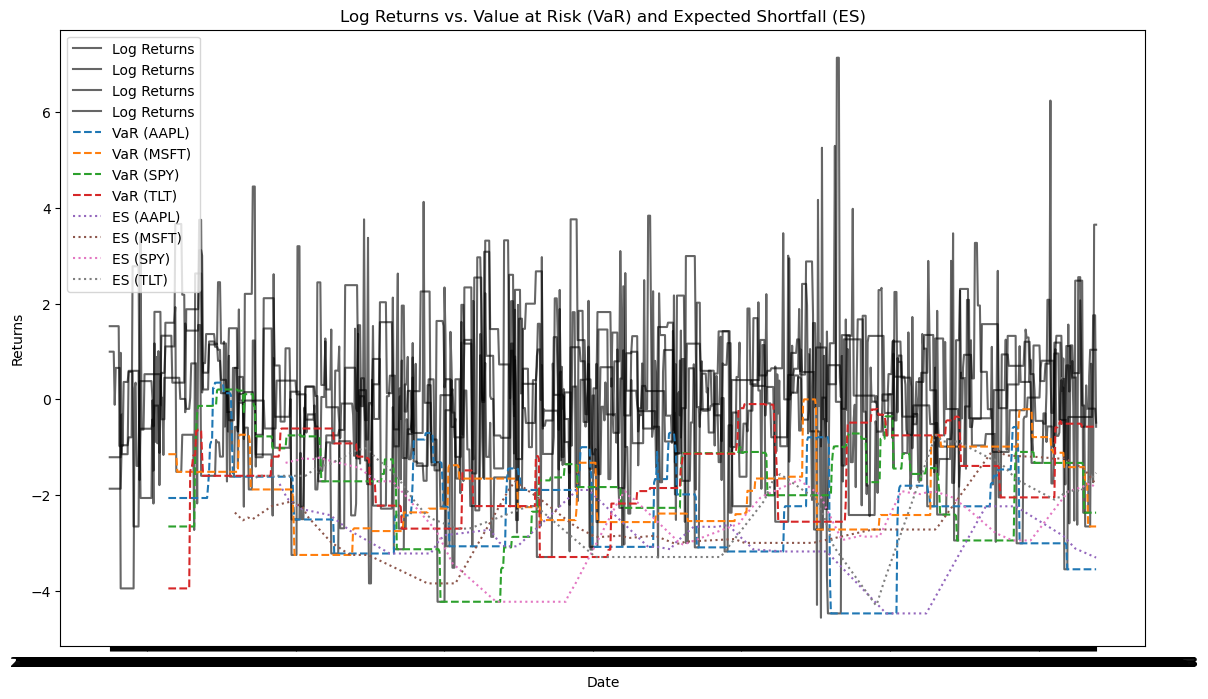

In [36]:
import matplotlib.pyplot as plt

# 可视化 Log Returns 与 VaR、ES 的比较
plt.figure(figsize=(14, 8))

# 绘制实际收益率
plt.plot(log_returns.index, log_returns, label="Log Returns", color="black", alpha=0.6)

# 绘制 VaR
for col in rolling_VaR.columns:
    plt.plot(rolling_VaR.index, rolling_VaR[col], label=f"VaR ({col})", linestyle="--")

# 绘制 ES
for col in rolling_ES.columns:
    plt.plot(rolling_ES.index, rolling_ES[col], label=f"ES ({col})", linestyle=":")

# 标注和图例
plt.title("Log Returns vs. Value at Risk (VaR) and Expected Shortfall (ES)")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend(loc="upper left")
plt.show()
